# Import necessary packages and libraries

In [4]:
import sys

# The current environment is automatically detected
# and set to either "GOOGLE_COLAB" or "LOCAL"
# depending on where the script is being run.

CURRENT_ENVIRONMENT = "GOOGLE_COLAB" if "google.colab" in sys.modules else "LOCAL"


In [5]:
import os
import shutil

if CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # If the utils directory exists, delete it
    if os.path.exists('/content/utils'):
        shutil.rmtree('/content/utils')

    # Copy the utils.zip file to the current directory
    !cp /content/drive/MyDrive/utils.zip /content/utils.zip

    # Unzip the utils.zip file
    !unzip -q /content/utils.zip -d /content/utils

    # Delete the utils.zip file
    !rm /content/utils.zip

In [6]:
# Set to True if you want to skip all EDA
# and data preprocessing steps, otherwise set to False.
SKIP_TO_TRAINING = False

In [7]:
if CURRENT_ENVIRONMENT == "LOCAL":
    from utils.constants import *
elif CURRENT_ENVIRONMENT == "GOOGLE_COLAB":
    from utils.constants_colab import *
elif CURRENT_ENVIRONMENT == "KAGGLE":
    from utils.constants_kaggle import *

In [8]:
import os
from utils.zipper import read_file, write_file

install_file = os.path.join(DATA_DIR, "install.txt")

# Create the directory if it does not exist
os.makedirs(DATA_DIR, exist_ok=True)

install_content = read_file(install_file)

if ENVIRONMENT == "LOCAL":
    requirements_file = "requirements.txt"
    requirements_content = read_file(requirements_file)
    if install_content != requirements_content:
        get_ipython().system("pip install -r requirements.txt")
        write_file(install_file, requirements_content)
elif ENVIRONMENT == "GOOGLE_COLAB" and not SKIP_TO_TRAINING:
    if install_content != "imagehash":
        get_ipython().system("pip install imagehash")
        write_file(install_file, "imagehash")

In [9]:
if ENVIRONMENT == "LOCAL":
    from utils.cache import reload_custom_libraries

    # Refresh library cache
    reload_custom_libraries()

In [10]:
if ENVIRONMENT == "LOCAL":
    from utils.zipper import zip_dir

    # Zip the reloaded libraries to be used in Google Colab
    zip_dir(UTILS_DIR, f"{ZIPPED_RESOURCES_DIR}/utils.zip")

In [11]:
from utils.zipper import unzip_file

if ENVIRONMENT != "LOCAL" or (ENVIRONMENT == "LOCAL"):
    # Check if the zipped preprocessed datasets file exists and ROOT_DATASET_DIR does not exist
    if os.path.exists(PREPROCESSED_DATASETS_ZIP):
        print("Cached preprocessed datasets found.")
        if not os.path.exists(ROOT_DATASET_DIR):
            print("Extracting preprocessed datasets...")
            unzip_file(
                PREPROCESSED_DATASETS_ZIP,
                PREPROCESSED_DATASETS_EXTRACT_DIR,
            )
            print("Preprocessed datasets extracted.")
        else:
            print("Directory with preprocessed datasets found. Skipping extraction...")
    else:
        print("Cached preprocessed datasets not found. Skipping extraction...")

Cached preprocessed datasets not found. Skipping extraction...


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from PIL import ImageFile
import os, sys
from tqdm.notebook import tqdm
from utils.image_process import (
        get_category_styles,
        process_images,
        get_category_image_paths,
        resize_images,
        get_majority_class,
        identify_minority_classes,
        calculate_category_oversampling,
        calculate_style_oversampling,
        oversample_minority_classes,
    )
import sys
sys.path.append("../FURNITURE-CLASSIFIER")



# Introduction

## Problem Statement
The assignment requires us to handle an image classification project, in which we will have to build 3 models to solve the task of furniture classification. With the dataset has been provided, we will need to finish the following task

Task 1: Classify furniture item by their categories

Task 2: Classify the furniture item and suggest 10 similar items in their category

Task 3: Classify furniture item base on their furniture style

# Machine Learning Pipeline

## Step 1: Exploratory Data Analysis

Understanding the dataset plays a crucial part in a Machine Learning project, since it will provide a thorough look on what tends to happen with the dataset, as well as its characteristics. From there, the appropriate preprocessing and training methods can be used for training processes, optimizing the outcome of the model.

In this project, we are handling a dataset of images relating to furniture categories (task 1 and 2), as well as their styles (task 3), which will then be processed and trained. The common outcome is to provide the highest-accuracy label for the images, in addition to suggesting the closest-similarity images for the predicted one.

First, we will look at the dataset to observe its characteristics. Some of them are dataset capacity, file extensions, and count for each of the category. 

# Get a general view of the dataset

In [13]:
print(DATASET_DIR)

./data/datasets/raw


In [14]:
data = tf.keras.utils.image_dataset_from_directory(DATASET_DIR)

Found 90082 files belonging to 6 classes.


# EDA

In [15]:
categories = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]

paths = {
    category: get_category_image_paths(DATASET_DIR, category)
    for category in categories
    }

print("Successfully extracted all paths!")

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths!


In [19]:
if not SKIP_TO_TRAINING:
    # Calculate the total

    total = 0

    # Print the amount for each category

    for category in categories:

        amount = len(paths[category])

        print(f"Amount of {category}: {amount}")

        total += amount

    # Print the total

    print("Total:", total)

Amount of beds: 6578
Amount of chairs: 22053
Amount of dressers: 7870
Amount of lamps: 32402
Amount of sofas: 4080
Amount of tables: 17100
Total: 90083


Through manual evaluation of the dataset, we have retrieve an anomaly files in the dataset with its path as: 

./data/datasets/lamps/modern/11286modern-lighting.jpg

To solve the issue with this file, we have decided to remove it from the dataset


In [ ]:
import os
if os.path.exists(./data/datasets/lamps/modern/11286modern-lighting.jpg):
  os.remove(./data/datasets/lamps/modern/11286modern-lighting.jpg)
else:
  print("The file does not exist")

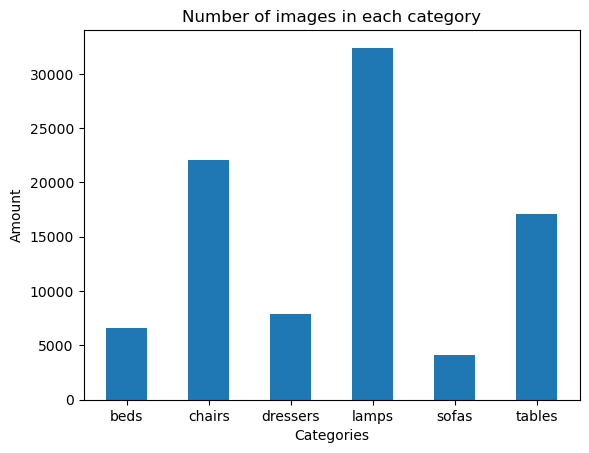

In [18]:
if not SKIP_TO_TRAINING:
    plt.bar(paths.keys(), [len(v) for v in paths.values()], width=0.5)
    plt.title("Number of images in each category")
    plt.xlabel("Categories")
    plt.ylabel("Amount")
    plt.show()

In [20]:
image_paths_list = [paths[category] for category in categories]

In [22]:
import cv2
import numpy as np

def calculate_image_statistics(image_paths_list):
    # Initialize variables to store aggregate statistics
    total_pixels = 0
    sum_pixels = np.array([0.0, 0.0, 0.0])  # Assuming RGB images

    # Loop through each list of image paths
    for image_paths in image_paths_list:
        # Loop through each image path in the list
        for image_path in image_paths:
            # Read the image
            image = cv2.imread(image_path)
            
            # Convert the image to float32 for accurate calculations
            image = image.astype(np.float32) / 255.0
            
            # Compute statistics
            total_pixels += image.size / 3  # Assuming RGB images
            sum_pixels += np.sum(image, axis=(0, 1))

    # Compute aggregate statistics
    mean_pixels = sum_pixels / total_pixels
    mean_pixel_value = np.mean(mean_pixels)
    std_dev_pixel_value = np.std(mean_pixels)
    min_pixel_value = np.min(mean_pixels)
    max_pixel_value = np.max(mean_pixels)

    return {
        "mean_pixel_value": mean_pixel_value,
        "std_dev_pixel_value": std_dev_pixel_value,
        "min_pixel_value": min_pixel_value,
        "max_pixel_value": max_pixel_value
    }

# Calculate image statistics
image_stats = calculate_image_statistics(image_paths_list)

# Print image statistics
print("Image Statistics:")
print(f"Mean Pixel Value: {image_stats['mean_pixel_value']}")
print(f"Standard Deviation of Pixel Value: {image_stats['std_dev_pixel_value']}")
print(f"Minimum Pixel Value: {image_stats['min_pixel_value']}")
print(f"Maximum Pixel Value: {image_stats['max_pixel_value']}")


AttributeError: 'NoneType' object has no attribute 'size'

Checking for file types

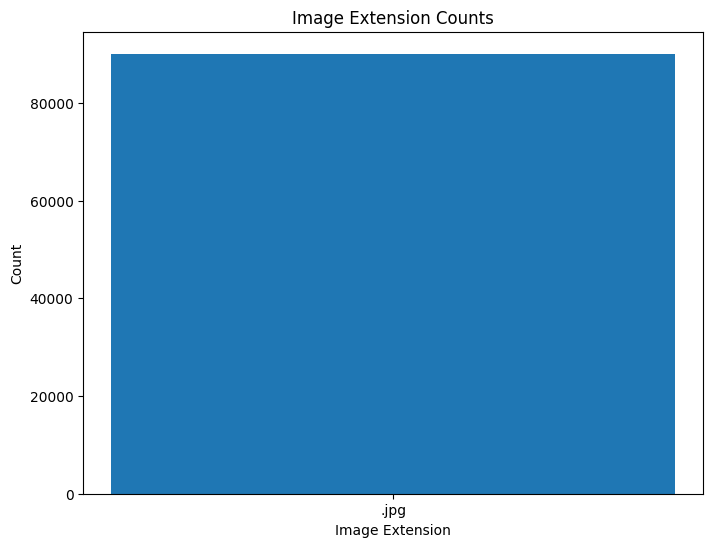

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_extension_counts(image_paths_list):
    extension_counts = {}
    
    # Iterate over each image path list
    for image_paths in image_paths_list:
        # Iterate over each image path in the list
        for image_path in image_paths:
            # Extract the file extension
            extension = os.path.splitext(image_path)[1]
            # Increment the count for the extension
            extension_counts[extension] = extension_counts.get(extension, 0) + 1
    
    # Convert extension counts dictionary to lists for plotting
    extensions = list(extension_counts.keys())
    counts = list(extension_counts.values())
    
    # Plot the extension counts
    plt.figure(figsize=(8, 6))
    plt.bar(extensions, counts, width = 0.5)
    plt.xlabel('Image Extension')
    plt.ylabel('Count')
    plt.title('Image Extension Counts')
    plt.show()

# Example image paths list


# Plot the extension counts for the image paths list
plot_extension_counts(image_paths_list)


With this plot, we could be sure that the dataset only contains image files with JPEG type

Get amount of image size and visualize the data


Size counts for List 1:
   Size (width, height)  Count
0           (350, 350)     41
1           (224, 224)   6537

Size counts for List 2:
   Size (width, height)  Count
0           (350, 350)  22053

Size counts for List 3:
   Size (width, height)  Count
0           (350, 350)   7870
An error occurred: [Errno 13] Permission denied: 'D:\\Assignment2\\furniture-classifier\\data\\datasets\\raw\\lamps\\Modern\\11286modern-lighting.jpg'

Size counts for List 4:
   Size (width, height)  Count
0           (350, 350)  32401

Size counts for List 5:
   Size (width, height)  Count
0           (350, 350)   4080

Size counts for List 6:
   Size (width, height)  Count
0           (350, 350)  17099
1           (500, 446)      1


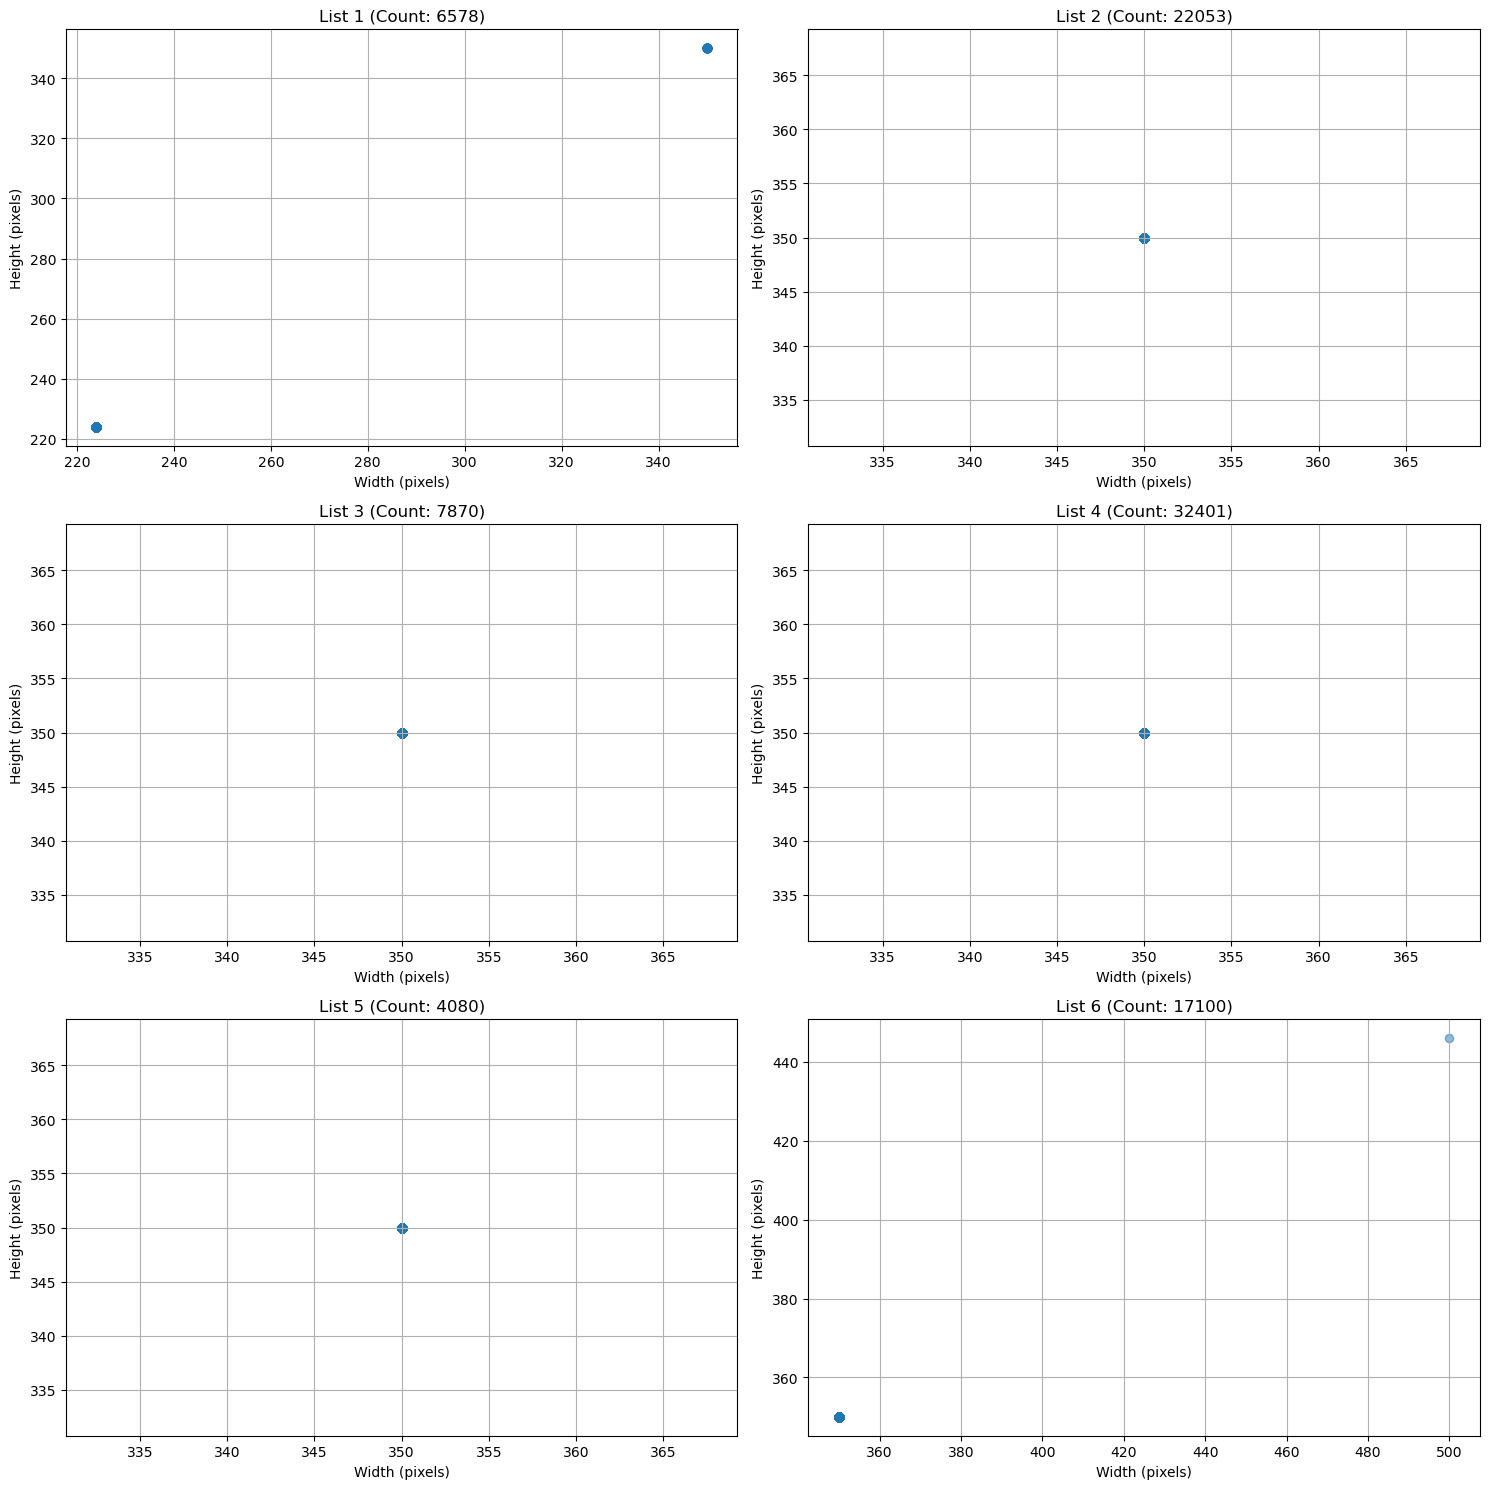

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except FileNotFoundError:
        print(f"The file at path {image_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    return None

def generate_plot_data_and_counts(image_paths):
    sizes = [get_image_size(image_path) for image_path in image_paths if get_image_size(image_path) is not None]
    size_counts = {}
    if sizes:
        widths = [size[0] for size in sizes]
        heights = [size[1] for size in sizes]
        for size in sizes:
            if size in size_counts:
                size_counts[size] += 1
            else:
                size_counts[size] = 1
        return widths, heights, size_counts
    return [], [], {}

def plot_individual_subplots(image_paths_list):
    num_lists = len(image_paths_list)
    num_cols = 2  # Number of columns in the subplot grid
    num_rows = (num_lists + num_cols - 1) // num_cols  # Calculate rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten the 2D array of axes

    for i, image_paths in enumerate(image_paths_list):
        widths, heights, size_counts = generate_plot_data_and_counts(image_paths)
        if widths and heights:
            axes[i].scatter(widths, heights, alpha=0.5)
            axes[i].set_title(f'List {i+1} (Count: {sum(size_counts.values())})')
            axes[i].set_xlabel('Width (pixels)')
            axes[i].set_ylabel('Height (pixels)')
            axes[i].grid(True)

            # Create a DataFrame for the size counts
            size_counts_df = pd.DataFrame(list(size_counts.items()), columns=['Size (width, height)', 'Count'])
            print(f"\nSize counts for List {i+1}:\n", size_counts_df)
        else:
            axes[i].set_visible(False)  # Hide subplot if no valid images

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot image sizes from all lists
plot_individual_subplots(image_paths_list)


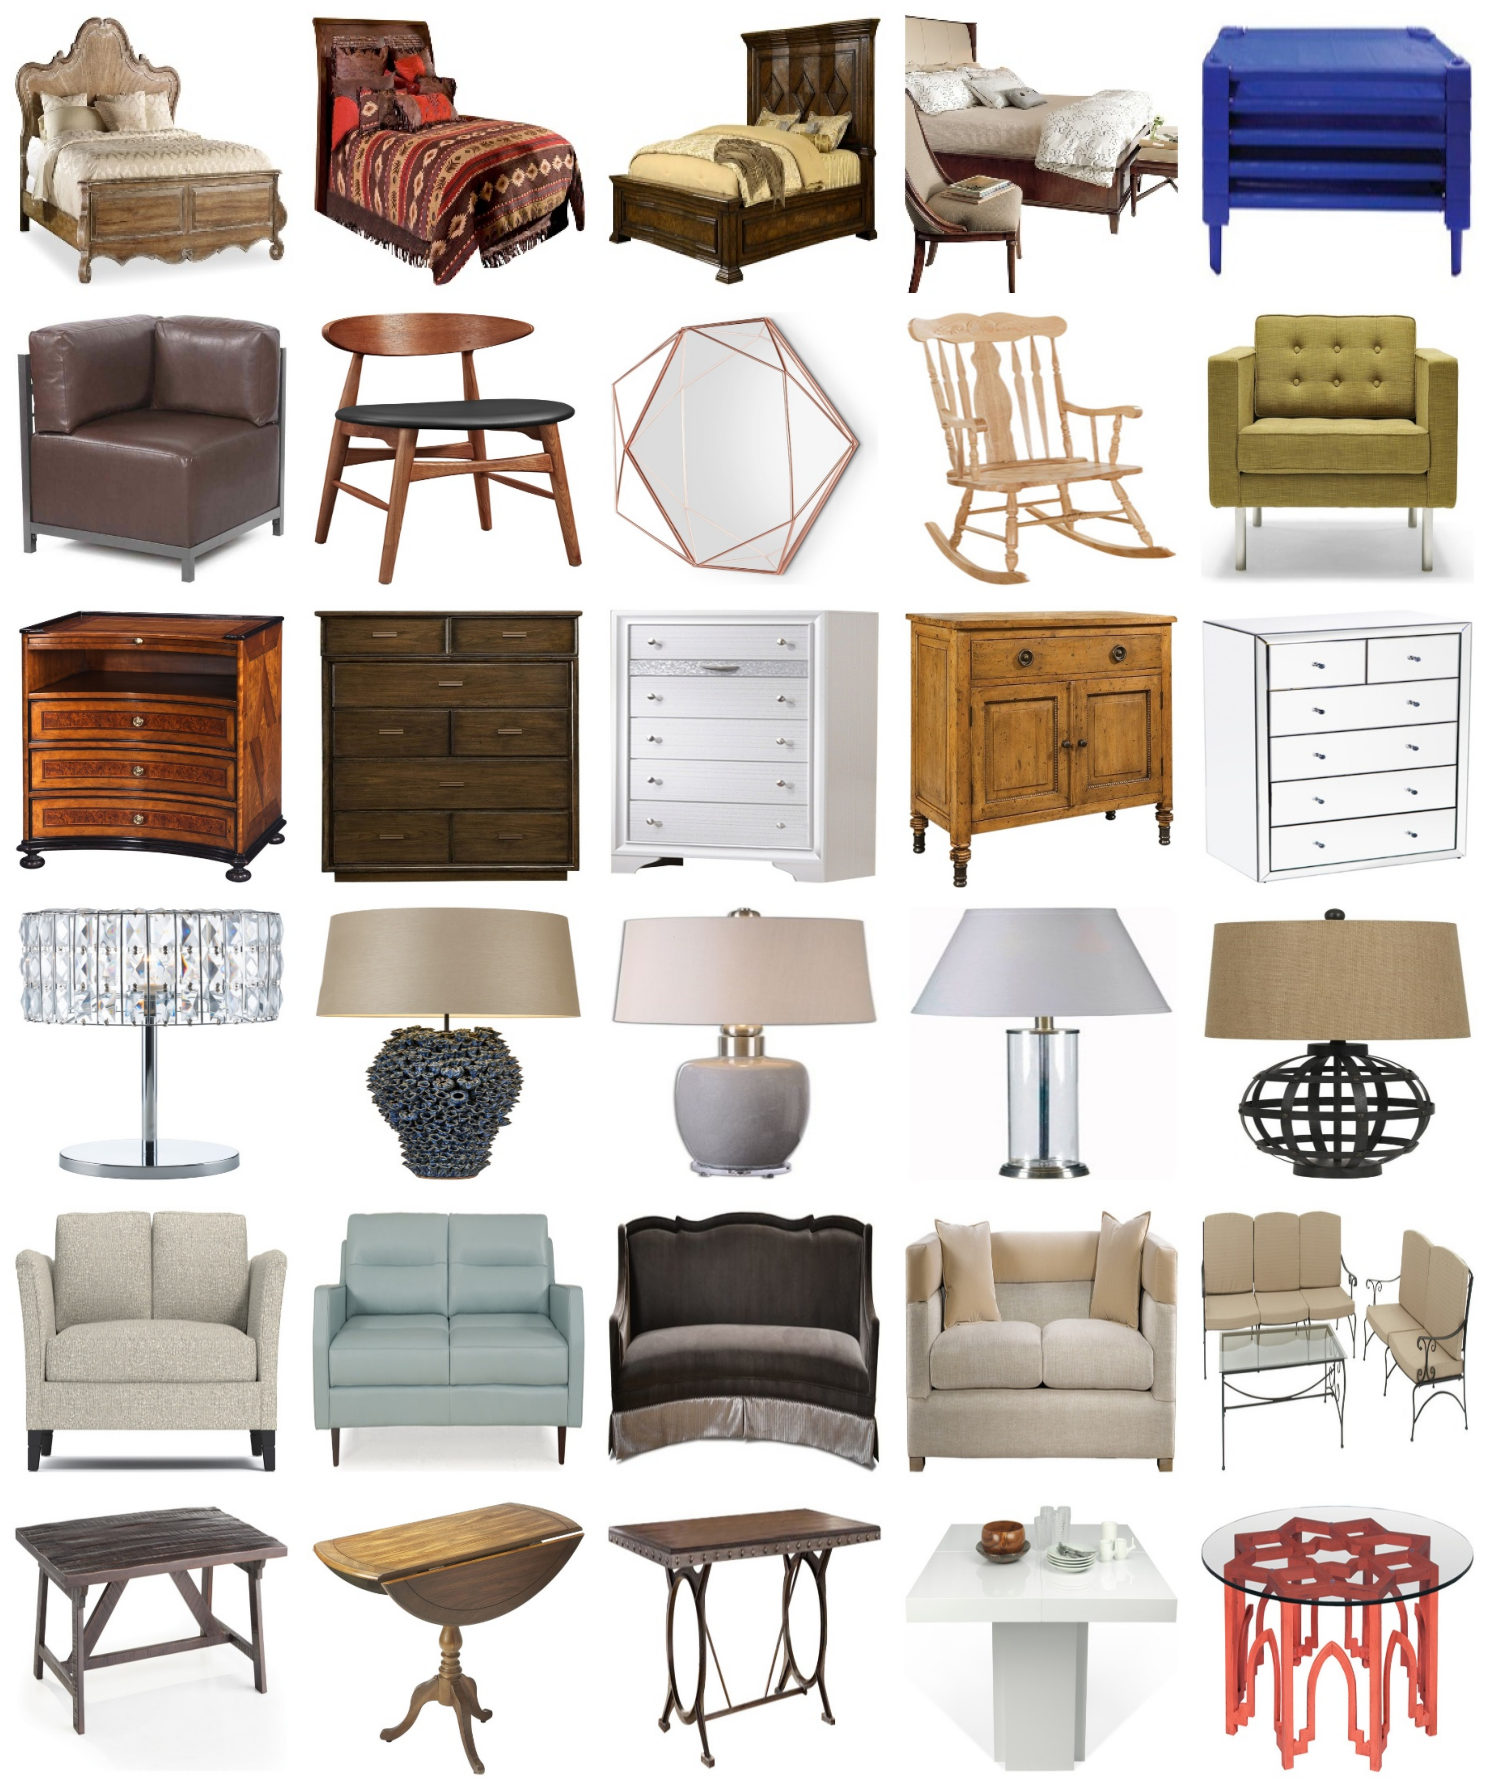

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

def visualize_sample_images(image_paths_list, category_names, samples_per_category=5):
    num_categories = len(image_paths_list)
    
    fig, axes = plt.subplots(num_categories, samples_per_category, figsize=(15, num_categories * 3))
    
    for i, (image_paths, category_name) in enumerate(zip(image_paths_list, category_names)):
        sample_images = random.sample(image_paths, min(samples_per_category, len(image_paths)))
        
        for j, image_path in enumerate(sample_images):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
        
        axes[i, 0].set_ylabel(category_name, size='large')

    plt.tight_layout()
    plt.show()


# Visualize sample images
visualize_sample_images(image_paths_list, categories)


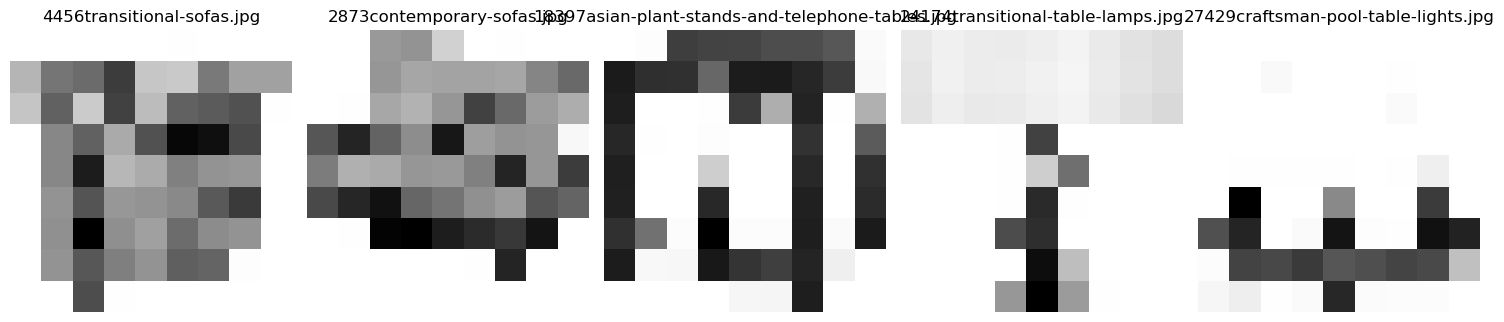

In [ ]:
import cv2
import random
from matplotlib import pyplot as plt

def load_convert_and_downscale_images(image_paths, num_samples=5, size=(9, 9)):
    processed_images = []
    sampled_paths = random.sample(image_paths, min(num_samples, len(image_paths)))

    for image_path in sampled_paths:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Failed to read image at path {image_path}")
            continue
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        downscaled_image = cv2.resize(gray_image, size)
        processed_images.append((image_path, downscaled_image))
    return processed_images

def visualize_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, (image_path, image) in enumerate(images):
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(image_path.split('/')[-1])  # Show file name

    plt.tight_layout()
    plt.show()

# Flatten the list of lists into a single list of image paths
image_paths = [path for sublist in image_paths_list for path in sublist]

# Load, convert to grayscale, and downscale images
processed_images = load_convert_and_downscale_images(image_paths, num_samples=5, size=(9, 9))

# Visualize downscaled grayscale images
visualize_images(processed_images)


### Visualization

In [ ]:
# Calculate the total

total = 0

# Print the amount for each category

for category in categories:

    amount = len(paths[category])

    print(f"Amount of {category}: {amount}")

    total += amount

    # Print the total

print("Total:", total)

Amount of beds: 6578
Amount of chairs: 22053
Amount of dressers: 7870
Amount of lamps: 32402
Amount of sofas: 4080
Amount of tables: 17100
Total: 90083


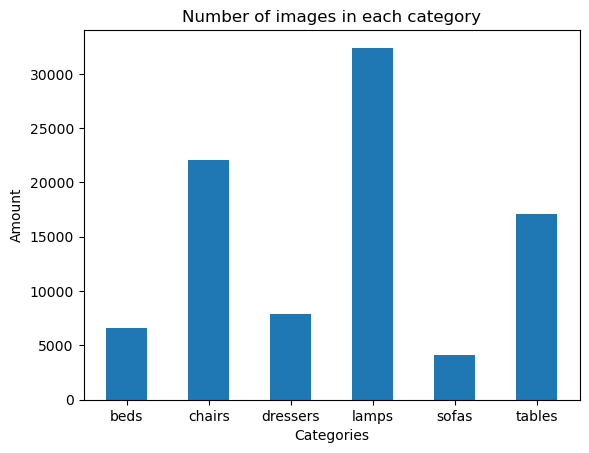

In [ ]:
plt.bar(paths.keys(), [len(v) for v in paths.values()], width=0.5)
plt.title("Number of images in each category")
plt.xlabel("Categories")
plt.ylabel("Amount")
plt.show()

## Conclusion

- The dataset contains 6 categories of items with 90082 items total
- The dataset contains all file with JPEG type
- The dataset contains image mainly in two dimensions: 224x224 and 350x350. However there are one anomaly dimensions in the table category which is: 500x446

# Data Preprocessing

## Data cleaning

Getting length of all path in raw dataset

In [ ]:
categories = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]

paths = {
    category: get_category_image_paths(DATASET_DIR, category)
    for category in categories
    }

print("Successfully extracted all paths!")

Getting image path for category 'beds':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'chairs':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'dressers':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'lamps':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'sofas':   0%|          | 0/17 [00:00<?, ?it/s]

Getting image path for category 'tables':   0%|          | 0/17 [00:00<?, ?it/s]

Successfully extracted all paths!


Check and remove duplication

Visualize data after removing duplicate images

In [ ]:
# Calculate the total

total = 0

# Print the amount for each category

for category in categories:

    amount = len(paths[category])

    print(f"Amount of {category}: {amount}")

    total += amount

# Print the total

print("Total:", total)

Check the size in each categories

In [ ]:
# Define a dictionary to store the dataframes
    # each category in df_dims is data[category][imageSizes]
df_dims = {
    category: pd.DataFrame(
        data[category]["imageSizes"], columns=["width", "height"]
    )
    for category in categories
}

print("Successfully extracted all dimensions!")

TypeError: 'BatchDataset' object is not subscriptable

NameError: name 'df_dims' is not defined

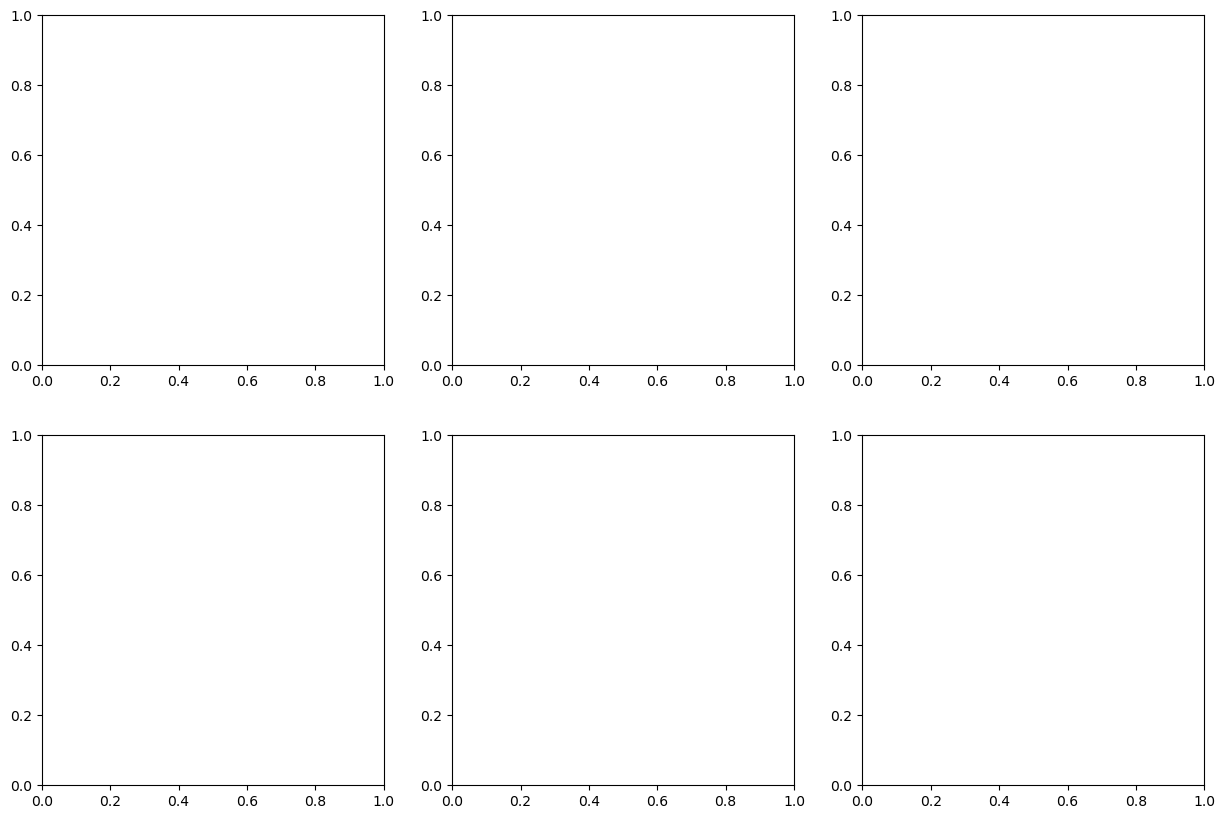

In [ ]:
# Define the number of rows and columns for the subplot grid
n_rows = 2
n_cols = 3

# Create the subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Flatten the axes array
axs = axs.flatten()

# Iterate over the categories and axes
for ax, category in zip(axs, categories):
    # Create the scatter plot for the current category
    df_dims[category].plot.scatter(
        x="width", y="height", ax=ax, title=category.capitalize()
    )

    # Adjust the layout
plt.tight_layout()
plt.show()

In [ ]:
for category in categories:
    print(category.capitalize())
    display(df_dims[category].describe().T)

Beds


NameError: name 'df_dims' is not defined

As the size in each categories still contains different image sizes of 224x224, 350x350 and one outliers at 500x446.
We will start with resizing all images to 350x350. Here are some reasons:
- The vast majority of the images are already at 350x350. Upscaling the smaller images will introduce minimal distortion compared to downscaling the majority to 224x224.
- Upscaling generally retains more information from the original image than downscaling. While some interpolation artifacts might be introduced, they are less likely to significantly impact model performance compared to the information loss from downscaling.
- The single image with a size of 500x448 is an outlier. which we can either upscale it to match the majority or exclude it from our dataset without significant impact.

### Image resizing

In [ ]:
for category in categories:
        print(
            f"Number of images in category '{category}': {len(data[category]['paths'])}"
        )

        # Total number of images
        total = sum(len(data[category]["paths"]) for category in categories)
        print(f"Total number of images: {total}")

TypeError: 'BatchDataset' object is not subscriptable

### Getting path from cleaned dataset

In [ ]:
cleaned_dir = CLEANED_DATASET_DIR
cleaned_beds_path = image_process.image_path(cleaned_dir, "beds")
cleaned_chairs_path = image_process.image_path(cleaned_dir, "chairs")
cleaned_dressers_path = image_process.image_path(cleaned_dir, "dressers")
cleaned_lamps_path = image_process.image_path(cleaned_dir, "lamps")
cleaned_sofas_path = image_process.image_path(cleaned_dir, "sofas")
cleaned_tables_path = image_process.image_path(cleaned_dir, "tables")

### Checking for duplicates

In [ ]:
image_process.imgDupchecks(beds_path)
image_process.imgDupchecks(chairs_path)
image_process.imgDupchecks(dressers_path)
image_process.imgDupchecks(lamps_path)
image_process.imgDupchecks(sofas_path)
image_process.imgDupchecks(tables_path)

### Data Augmentation

This is a time-consuming task, be aware that it will take a long time to run

In [ ]:
save_dir = PROCESSED_DATASET_DIR
image_process.augment_images(cleaned_beds_path,save_dir )
image_process.augment_images(cleaned_chairs_path,save_dir)
image_process.augment_images(cleaned_dressers_path,save_dir)
image_process.augment_images(cleaned_lamps_path,save_dir)
image_process.augment_images(cleaned_sofas_path,save_dir)
image_process.augment_images(cleaned_tables_path,save_dir)

After all of the above step, the data would ready to be input to the model, the data which can be use will be available in the .data/dataset/processed 